In [ ]:
import warnings; warnings.simplefilter("ignore")
import logging, sunpy; logging.getLogger('sunpy').setLevel(logging.ERROR)

The SunPy [@sunpy_community2020] is a community-developed, free, and open source Python package for solar data analysis [@2015CS; @2020JOSS; @2023FrASS].

In this post, I will reproduce Figure 1 (see below) of the 2023 SunPy paper [@2023FrASS] using the SunPy ecosystem. This is because one of the most important affiliated packages, `pfsspy` [@2020JOSSpfss], has been no longer developed since August 2023. The `pfsspy` package has been forked to [`sunkit-magex`](https://github.com/sunpy/sunkit-magex). Also, there are subtle differences in the `aiapy` package between 2023 and 2025. Therefore, I will basically follow the steps in [this code](https://github.com/sunpy/sunpy-frontiers-paper/tree/main/figures) provided by the authors of the 2023 SunPy paper, except that I will use the `sunkit-magex` package instead of the `pfsspy` package.

![Figure 1 of the 2023 SunPy paper [source](https://www.frontiersin.org/files/Articles/1076726/fspas-10-1076726-HTML-r1/image_m/fspas-10-1076726-g001.jpg)](./fspas-10-1076726-g001.jpg)

## Version Information

In [ ]:
import sys
print("Python version:", sys.version)

import numpy as np
print("NumPy version:", np.__version__)
import matplotlib
print("Matplotlib version:", matplotlib.__version__)
import astropy
print("Astropy version:", astropy.__version__)
import sunpy
print("SunPy version:", sunpy.__version__)
import sunpy_soar
print("sunpy-soar version:", sunpy_soar.__version__)
import sunkit_magex
print("sunkit-magex version:", sunkit_magex.__version__)

Python version: 3.12.11 | packaged by conda-forge | (main, Jun  4 2025, 14:29:09) [MSC v.1943 64 bit (AMD64)]
NumPy version: 2.2.6
Matplotlib version: 3.10.5
Astropy version: 7.1.0
SunPy version: 7.0.1
sunpy-soar version: 1.11.1
sunkit-magex version: 1.1.0


## Download HMI Synoptic Magnetogram for CR 2255

The SunPy paper (2023) said that the left panel of Figure1A shows the SDO/HMI synoptic magnetogram for Carrington rotation (CR) 2255 which began on 2022-03-08.

Let's start by checking that CR 2255 actually began on 2022-03-08.

In [ ]:
from sunpy.coordinates.sun import carrington_rotation_time

In [ ]:
carrington_rotation_time(2255)

<Time object: scale='utc' format='iso' value=2022-03-07 11:59:56.657>

CR 2255 actually began on 2022-03-07 12:00 UTC, which also can be found in [this page](https://space.umd.edu/pm/crn/).

We can download the HMI polar-filled full-CR synoptic magnetogram `hmi.synoptic_mr_polfil_720s` [@sun2018] for CR 2255 from JSOC using `sunpy.net.Fido`.

In [ ]:
from sunpy.net import Fido, attrs as a

In [ ]:
# Please replace the following email with your own email address registered with the JSOC.
jsoc_email = 'mgjeon@khu.ac.kr'

In [ ]:
q = Fido.search(
    a.Time('2022-03-07T12:00', '2022-03-07T12:00'),
    a.jsoc.Series('hmi.synoptic_mr_polfil_720s'),
    a.jsoc.PrimeKey('CAR_ROT', 2255),
    a.jsoc.Notify(jsoc_email)
)

In [ ]:
q

<sunpy.net.fido_factory.UnifiedResponse object>
Results from 1 Provider:

1 Results from the JSOCClient:
Source: http://jsoc.stanford.edu

TELESCOP  INSTRUME WAVELNTH CAR_ROT
-------- --------- -------- -------
 SDO/HMI HMI_SIDE1   6173.0    2255

In [ ]:
f = Fido.fetch(q, path='./data', overwrite=True)

In [ ]:
print(f)

['data\\hmi.synoptic_mr_polfil_720s.2255.Mr_polfil.fits']


We can load the fits file using `sunpy.map.Map`.

In [ ]:
from sunpy.map import Map

In [ ]:
m_hmi = Map(f)

In [ ]:
m_hmi.peek()

This is the same HMI synoptic magnetogram as shown in the left panel of Figure 1A in the SunPy paper (2023).

## Select Location of AR

We identify the center of the active region (AR) of interest visually from the HMI synoptic magnetogram. 

In [ ]:
import astropy.units as u
from astropy.coordinates import SkyCoord

In [ ]:
m_hmi.coordinate_frame

<HeliographicCarrington Frame (obstime=2022-03-21T03:51:33.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2022-03-21T03:51:33.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., -7.02110576, 1.48994814e+11)>)>

In [ ]:
ar_center = SkyCoord(lon=65*u.deg, lat=15*u.deg, frame=m_hmi.coordinate_frame)

We can plot this coordinate on the HMI map.

In [ ]:
import matplotlib.pyplot as plt

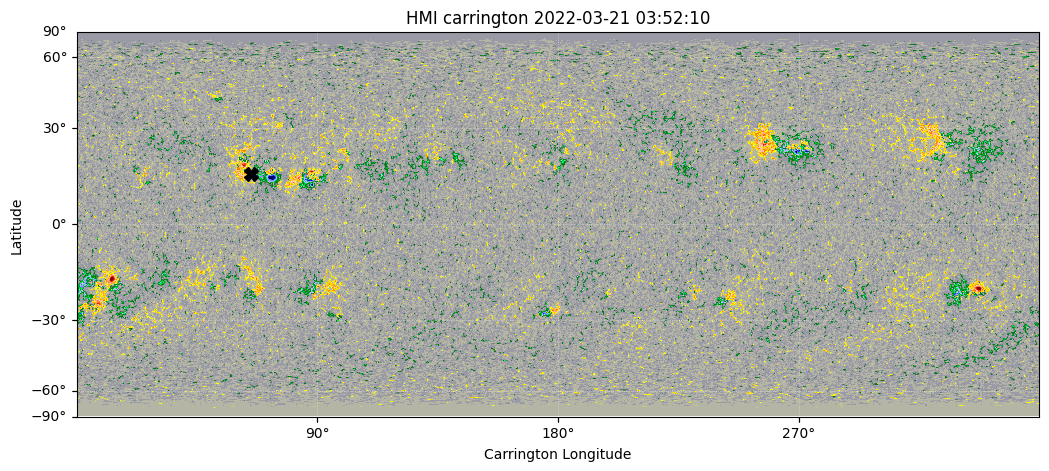

In [ ]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111, projection=m_hmi)
m_hmi.plot(axes=ax)
ax.plot_coord(ar_center, marker='X', color='k', markersize=10);

The default obstime of the carrington map is halfway through the carrington rotation.

In [ ]:
m_hmi.coordinate_frame.obstime

<Time object: scale='utc' format='isot' value=2022-03-21T03:51:33.000>

In [ ]:
car_start = carrington_rotation_time(2255)
car_end = carrington_rotation_time(2256)
print('CR 2255 start   ', car_start)
print('CR 2255 end     ', car_end)
car_halfway = car_start + (car_end - car_start) / 2
print('CR 2255 halfway ', car_halfway)

CR 2255 start    2022-03-07 11:59:56.657
CR 2255 end      2022-04-03 19:19:29.900
CR 2255 halfway  2022-03-21 03:39:43.279


Since a synoptic map is comprised of observations from many different times, we look up the obstime associated with our selected longitude and use this to correct our original AR coordinate

In [ ]:
ar_date = carrington_rotation_time(2255, ar_center.lon)
ar_date

<Time object: scale='utc' format='iso' value=2022-03-29 21:04:15.174>

In [ ]:
change_obstime = lambda x,y: SkyCoord(x.replicate(observer=x.observer.replicate(obstime=y), obstime=y))

In [ ]:
ar_center_corrected = change_obstime(ar_center, ar_date)
ar_center_corrected

<SkyCoord (HeliographicCarrington: obstime=2022-03-29 21:04:15.174, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2022-03-29 21:04:15.174, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., -7.02110576, 1.48994814e+11)>): (lon, lat) in deg
    (65., 15.)>

## Download EUV data for AR

We will download the EUV data from SDO/AIA, STEREO-A/SECCHI/EUVI, and Solar Orbiter/EUI/FSI.

First, we define the time range of interest.

In [ ]:
tr = a.Time(ar_date-2*u.min, ar_date+2*u.min)
tr

<sunpy.net.attrs.Time(2022-03-29 21:02:15.174, 2022-03-29 21:06:15.174)>

We construct a search query for 171 Å EUV data from SDO/AIA and STEREO-A/SECCHI/EUVI. This will search the Virtual Solar Observatory (VSO).

In [ ]:
aia_or_euvi = ((a.Instrument('AIA') | a.Instrument('EUVI'))
                & a.Wavelength(171*u.angstrom)
                & a.Sample(5*u.min))

We construct a search query for 174 Å EUV data from Solar Orbiter/EUI/FSI. This will search the Solar Oriter Archive (SOAR) using the `sunpy-soar` package.

In [ ]:
eui = a.Level(2) & a.soar.Product('EUI-FSI174-IMAGE')

In [ ]:
q = Fido.search(tr, aia_or_euvi | eui)

In [ ]:
q

<sunpy.net.fido_factory.UnifiedResponse object>
Results from 3 Providers:

1 Results from the VSOClient:
Source: https://sdac.virtualsolar.org/cgi/search
Data retrieval status: https://docs.virtualsolar.org/wiki/VSOHealthReport
Total estimated size: 67.789 Mbyte

       Start Time               End Time        Source Instrument   Wavelength   Provider  Physobs  Wavetype Extent Width Extent Length Extent Type   Size  
                                                                     Angstrom                                                                        Mibyte 
----------------------- ----------------------- ------ ---------- -------------- -------- --------- -------- ------------ ------------- ----------- --------
2022-03-29 21:02:21.000 2022-03-29 21:02:22.000    SDO        AIA 171.0 .. 171.0     JSOC intensity   NARROW         4096          4096    FULLDISK 64.64844

1 Results from the VSOClient:
Source: https://sdac.virtualsolar.org/cgi/search
Data retrieval status: https://docs.virtualsolar.org/wiki/VSOHealthReport

       Start Time               End Time         Source  Instrument   Wavelength   Provider  Physobs  Wavetype Extent Type   Size  
                                                                       Angstrom                                             Mibyte 
----------------------- ----------------------- -------- ---------- -------------- -------- --------- -------- ----------- --------
2022-03-29 21:03:00.000 2022-03-29 21:03:02.000 STEREO_A     SECCHI 171.0 .. 175.0      SSC intensity   NARROW    FULLDISK -0.00098

1 Results from the SOARClient:

Instrument   Data product   Level        Start time               End time        Filesize            SOOP Name            Detector Wavelength
                                                                                   Mbyte                                                      
---------- ---------------- ----- ----------------------- ----------------------- -------- ------------------------------- -------- ----------
       EUI eui-fsi174-image    L2 2022-03-29 21:04:45.298 2022-03-29 21:04:55.298    5.593 L_FULL_HRES_HCAD_Eruption-Watch      FSI      174.0

Note that `Fido` returns three results (one for each instrument) and that two out of the three of these are from the VSO and one is from the SOAR.

In [ ]:
files = Fido.fetch(q, path='./data', overwrite=True)

In [ ]:
print(sorted(files))

['data\\20220329_210300_n5euA.fts', 'data\\aia.lev1.171A_2022_03_29T21_02_21.35Z.image_lev1.fits', 'data\\solo_L2_eui-fsi174-image_20220329T210445298_V02.fits']


In [ ]:
m_secchi, m_aia, m_eui = Map(sorted(files))

Using the metadata provided in each file, we can plot the relative locations of the three spacecraft.

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
# Plot the Sun
ax.plot(0, 0, marker='o', markersize=20, label='Sun', color='yellow')
# Plot the spacecraft locations
for m in [m_aia, m_eui, m_secchi]:
    sat = m.observatory
    coord = m.observer_coordinate
    ax.plot(coord.lon.to('rad'), coord.radius.to(u.AU), 'o', label=sat)
ax.set_theta_zero_location('S')
ax.legend();

## Process EUV Data for AR

We prepare the SDO/AIA data [from level 1 to level 1.5](https://aiapy.readthedocs.io/en/stable/preparing_data.html) using `aiapy` package by (1) correcting the pointing keywords and (2) also correcting the instrument degradation.

In [ ]:
from aiapy.calibrate import update_pointing, correct_degradation
from aiapy.calibrate.util import get_pointing_table, get_correction_table

In [ ]:
pointing_table = get_pointing_table('JSOC', time_range=(m_aia.date-12*u.h, m_aia.date+12*u.h))

In [ ]:
pointing_table

<QTable length=8>
   ORIGIN    TELESCOP         DATE         ... AIA_GT4_PKT_ZCOEF_C AGT4_ZCC
                                           ...                             
   str12       str3          str20         ...       float64       float64 
------------ -------- -------------------- ... ------------------- --------
SDO/JSOC-SDP      SDO 2022-03-30T16:51:58Z ...                 0.0      0.0
SDO/JSOC-SDP      SDO 2022-03-30T19:47:27Z ...                 0.0      0.0
SDO/JSOC-SDP      SDO 2022-03-30T22:07:31Z ...                 0.0      0.0
SDO/JSOC-SDP      SDO 2022-03-31T01:40:36Z ...                 0.0      0.0
SDO/JSOC-SDP      SDO 2022-03-31T04:51:55Z ...                 0.0      0.0
SDO/JSOC-SDP      SDO 2022-03-31T07:53:59Z ...                 0.0      0.0
SDO/JSOC-SDP      SDO 2022-03-31T10:52:02Z ...                 0.0      0.0
SDO/JSOC-SDP      SDO 2022-03-31T13:41:38Z ...                 0.0      0.0

In [ ]:
correction_table = get_correction_table('JSOC')

In [ ]:
correction_table

<QTable length=665>
        DATE         VER_NUM  WAVE_STR WAVELNTH ... EFFA_P3 EFF_AREA  EFF_WVLN 
                                       Angstrom ...           cm2     Angstrom 
       str20          int64     str9   float64  ... float64 float64   float64  
-------------------- ------- --------- -------- ... ------- -------- ----------
2020-11-02T11:14:52Z      10 131_THICK    131.0 ...     0.0 0.101769 131.199997
2017-12-10T05:05:04Z       8 131_THICK    131.0 ...     0.0 0.092281 131.199997
2020-07-06T21:54:29Z       9 131_THICK    131.0 ...     0.0 0.101531 131.199997
2011-09-29T00:00:00Z       1 131_THICK    131.0 ...     0.0 0.097468 131.199997
2012-01-05T00:00:00Z       2 131_THICK    131.0 ...     0.0 0.075027 131.199997
2010-11-23T00:00:00Z       1 131_THICK    131.0 ...     0.0    0.097 131.199997
2012-09-26T00:00:00Z       3 131_THICK    131.0 ...     0.0 0.075027 131.199997
2011-04-29T00:00:00Z       1 131_THICK    131.0 ...     0.0    0.097 131.199997
2020-11-02T11:14:52Z      10  131_THIN    131.0 ...     0.0 1.223503 131.199997
                 ...     ...       ...      ... ...     ...      ...        ...
2020-11-02T11:14:52Z      10 335_THICK    335.0 ...     0.0 0.006929 335.399994
2020-11-02T11:14:52Z      10  335_THIN    335.0 ...     0.0 0.009789 335.399994
2020-07-06T21:54:47Z       9  335_THIN    335.0 ...     0.0 0.009279 335.399994
2020-11-19T19:00:00Z      10  94_THICK     94.0 ...     0.0 0.193237  93.900002
2020-11-02T11:14:52Z      10  94_THICK     94.0 ...     0.0  0.20261  93.900002
2020-07-06T21:54:28Z       9  94_THICK     94.0 ...     0.0 0.213493  93.900002
2020-07-06T21:54:28Z       9   94_THIN     94.0 ...     0.0  0.29744  93.900002
2020-11-19T19:00:00Z      10   94_THIN     94.0 ...     0.0  0.26922  93.900002
2020-11-02T11:14:52Z      10   94_THIN     94.0 ...     0.0 0.282278  93.900002

In [ ]:
m_aia.peek(vmin=0, vmax=8000)

In [ ]:
m_aia = correct_degradation(update_pointing(m_aia, pointing_table=pointing_table), correction_table=correction_table)

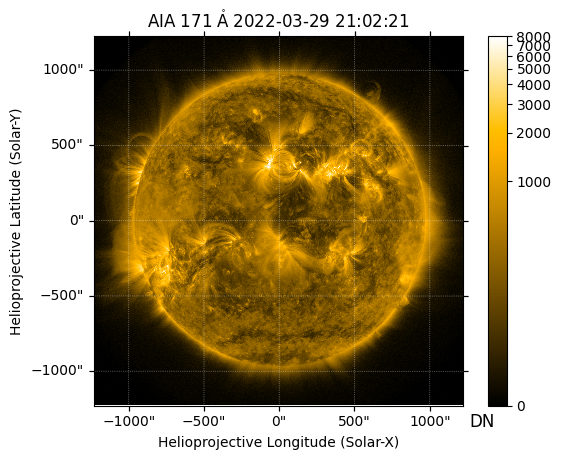

In [ ]:
m_aia.peek(vmin=0, vmax=8000)

The SDO/AIA and STEREO-A/SECCHI/EUVI data are not been normalized for exposure time, whereas the Solar Orbiter/EUI/FSI data (level 2) are normalized for exposure time.

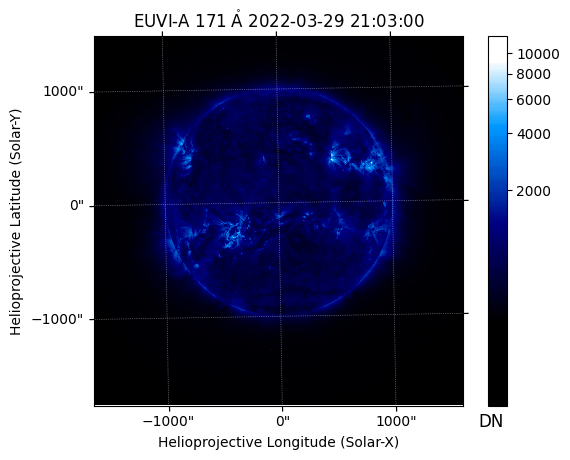

In [ ]:
m_secchi.peek()

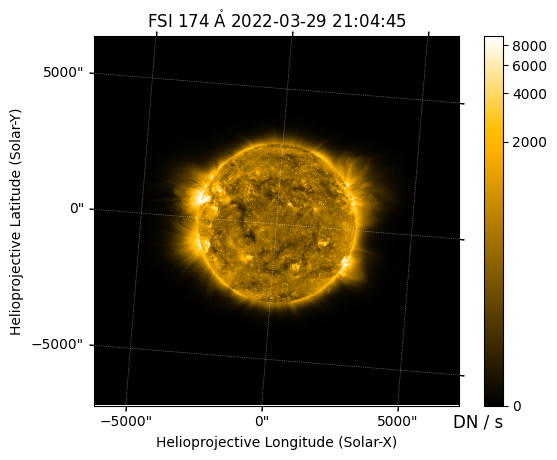

In [ ]:
m_eui.peek()

We normalize the SDO/AIA and STEREO-A/SECCHI/EUVI data for exposure time.

In [ ]:
m_aia = m_aia / m_aia.exposure_time
m_secchi = m_secchi / m_secchi.exposure_time

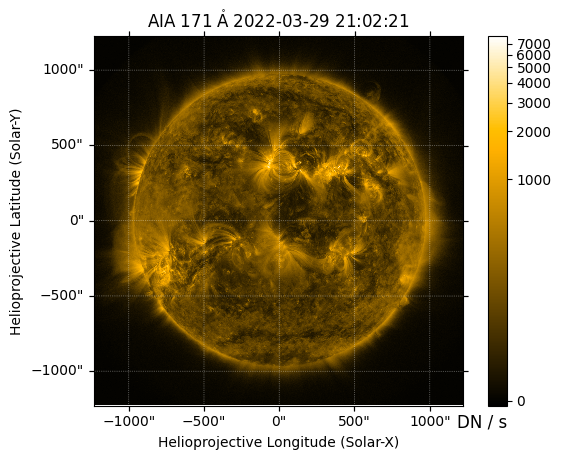

In [ ]:
m_aia.peek()

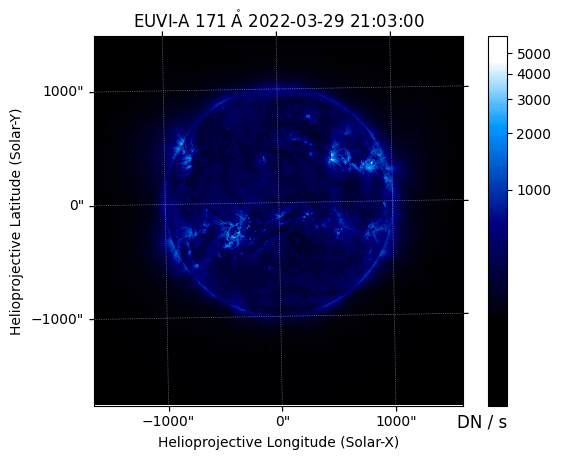

In [ ]:
m_secchi.peek()

We can plot the position of the corrected center of the AR on the EUV maps.

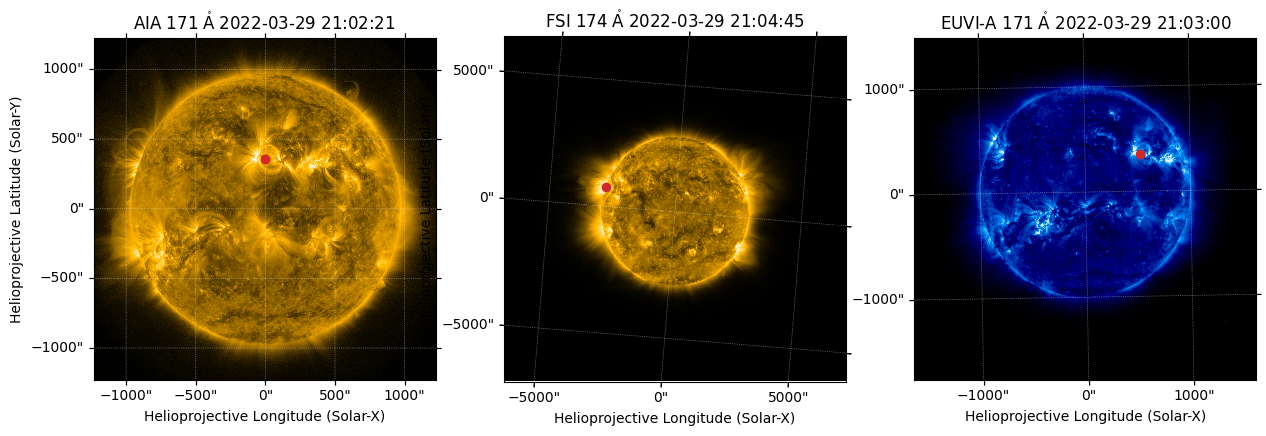

In [ ]:
fig = plt.figure(figsize=(15, 5))
for i, m in enumerate([m_aia, m_eui, m_secchi]):
    ax = fig.add_subplot(1, 3, i+1, projection=m)
    m.plot(axes=ax, clip_interval=(1, 99.99)*u.percent)
    ax.plot_coord(ar_center_corrected, marker='o', color='C3')

We can plot the region of interest on the EUV maps.

In [ ]:
ar_width = 700*u.arcsec
ar_height = 700*u.arcsec

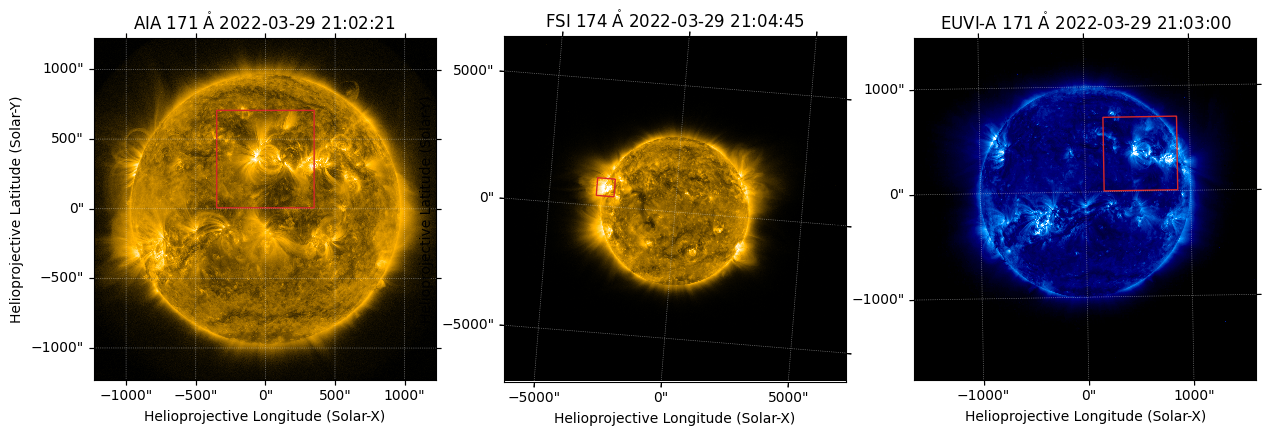

In [ ]:
fig = plt.figure(figsize=(15, 5))
for i, m in enumerate([m_aia, m_eui, m_secchi]):
    ax = fig.add_subplot(1, 3, i+1, projection=m)
    m.plot(axes=ax, clip_interval=(1, 99.99)*u.percent)
    ar_center_corrected_transformed = ar_center_corrected.transform_to(m.coordinate_frame)
    blc = SkyCoord(Tx=ar_center_corrected_transformed.Tx-ar_width/2,
                   Ty=ar_center_corrected_transformed.Ty-ar_height/2,
                   frame=ar_center_corrected_transformed)
    m.draw_quadrangle(blc, width=ar_width, height=ar_height, edgecolor='C3', lw=1)

We can rotate the maps such that the y-axis of the images is aligned with the solar north using `sunpy.map.Map.rotate`.

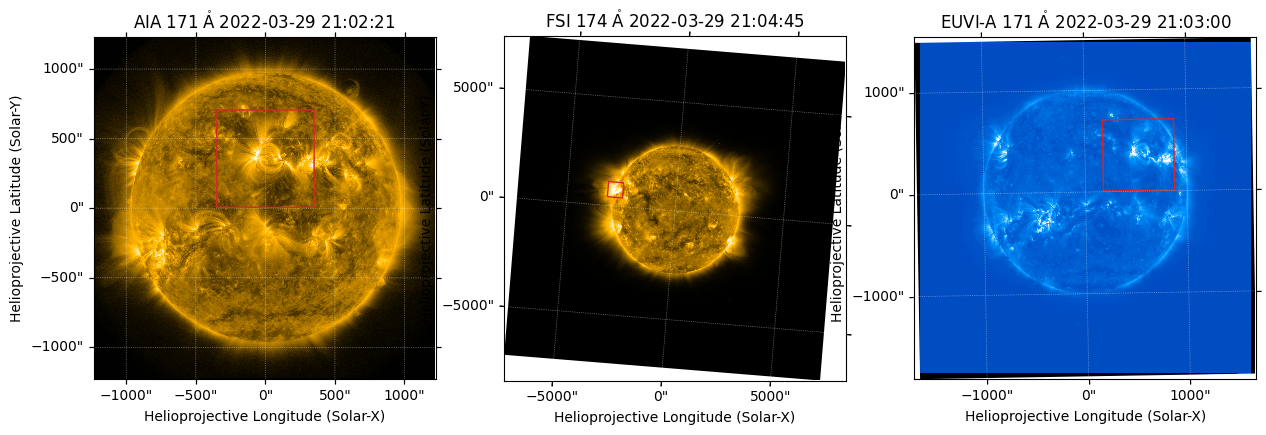

In [ ]:
fig = plt.figure(figsize=(15, 5))
for i, m in enumerate([m_aia, m_eui, m_secchi]):
    ax = fig.add_subplot(1, 3, i+1, projection=m)
    m_rot = m.rotate(missing=0.0)
    m_rot.plot(axes=ax, clip_interval=(1, 99.99)*u.percent)
    ar_center_corrected_transformed = ar_center_corrected.transform_to(m_rot.coordinate_frame)
    blc = SkyCoord(Tx=ar_center_corrected_transformed.Tx-ar_width/2,
                   Ty=ar_center_corrected_transformed.Ty-ar_height/2,
                   frame=ar_center_corrected_transformed)
    m_rot.draw_quadrangle(blc, width=ar_width, height=ar_height, edgecolor='C3', lw=1)

We can now crop each full disk image to the appropriate region.

In [ ]:
m_cutouts = []
for m in [m_aia, m_eui, m_secchi]:
    ar_center_corrected_transformed = ar_center_corrected.transform_to(m.coordinate_frame)
    blc = SkyCoord(Tx=ar_center_corrected_transformed.Tx-ar_width/2,
                   Ty=ar_center_corrected_transformed.Ty-ar_height/2,
                   frame=ar_center_corrected_transformed)
    # Each map is rotated prior to submapping such that the selection is aligned with the coordinate grid
    m_rot = m.rotate(missing=0.0)
    m_cutout = m_rot.submap(blc, width=ar_width, height=ar_height)
    m_cutouts.append(m_cutout)

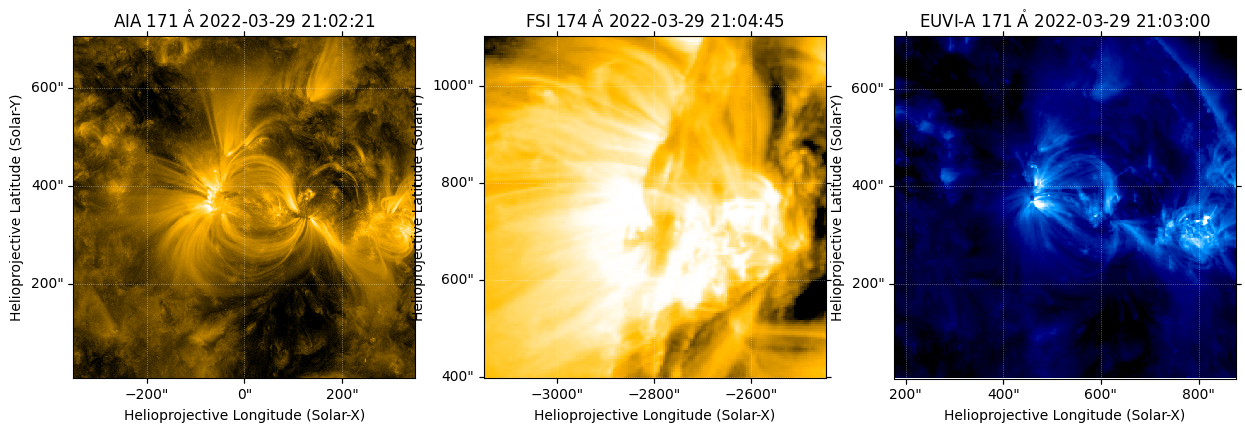

In [ ]:
fig = plt.figure(figsize=(15, 5))
for i, m in enumerate(m_cutouts):
    ax = fig.add_subplot(1, 3, i+1, projection=m)
    m.plot(axes=ax, clip_interval=(1, 99.99)*u.percent)

## Calculate PFSS from HMI Synoptic Magnetogram

We can calculate a potential field source surface (PFSS) solution from the HMI synoptic magnetogram using `sunkit-magex` package.

We first resample the HMI synoptic map to speed up the calculation of our field extrapolation.

In [ ]:
m_hmi.data.shape

(1440, 3600)

In [ ]:
m_hmi_resample = m_hmi.resample((1080, 540)*u.pix)

In [ ]:
m_hmi_resample.data.shape

(540, 1080)

In [ ]:
from sunkit_magex import pfss

In [ ]:
nr = 70    # number of cells in the radial direction
rss = 2.5  # radius of the source surface in R_sun
pfss_input = pfss.Input(m_hmi_resample, nr, rss)

In [ ]:
pfss_output = pfss.pfss(pfss_input)

Let's plot the radial component of the magnetic field at the source surface (2.5 Rs) and the polarity inversion lines (PILs).

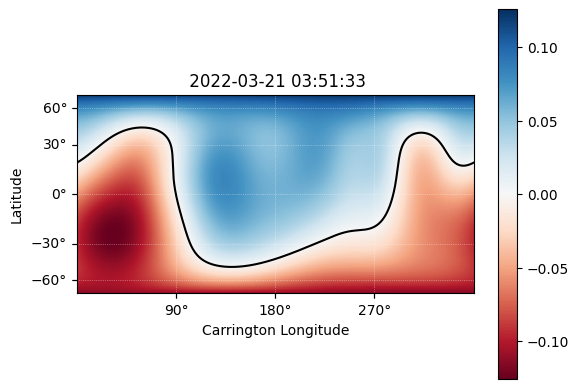

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=pfss_output.source_surface_br)
im = pfss_output.source_surface_br.plot(axes=ax)
ax.plot_coord(pfss_output.source_surface_pils[0], color='k')
fig.colorbar(im, ax=ax);

## Trace Magnetic Field Lines

Let's trace some field lines through the extrapolated field.

To do this, we need to choose a set of seed points from which to trace our field lines. We want to select only the seed points that are within a certain area around the active region. We need to make the following transformations because we want to express our boundaries in terms of the active region boundary as identified by our SDO/AIA cutout.

In [ ]:
change_obstime_frame = lambda x,y: x.replicate_without_data(observer=x.observer.replicate(obstime=y), obstime=y)

In [ ]:
new_frame = change_obstime_frame(m_hmi.coordinate_frame, m_cutouts[0].date)
new_frame

<HeliographicCarrington Frame (obstime=2022-03-29T21:02:21.350, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2022-03-29T21:02:21.350, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., -7.02110576, 1.48994814e+11)>)>

In [ ]:
blc_ar_synop = change_obstime(m_cutouts[0].bottom_left_coord.transform_to(new_frame),
                              m_hmi.date)
trc_ar_synop = change_obstime(m_cutouts[0].top_right_coord.transform_to(new_frame),
                              m_hmi.date)

We mask all those points that are above -10 G and fall outside of the bounding box defined above.

In [ ]:
masked_pix_y, masked_pix_x = np.where(m_hmi_resample.data < -1e1)
seeds = m_hmi_resample.pixel_to_world(masked_pix_x*u.pix, masked_pix_y*u.pix).make_3d()
in_lon = np.logical_and(seeds.lon > blc_ar_synop.lon, seeds.lon < trc_ar_synop.lon)
in_lat = np.logical_and(seeds.lat > blc_ar_synop.lat, seeds.lat < trc_ar_synop.lat)
seeds = seeds[np.where(np.logical_and(in_lon, in_lat))]
seeds

<HeliographicCarrington Coordinate (obstime=2022-03-21T03:51:33.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2022-03-21T03:51:33.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., -7.02110576, 1.48994814e+11)>): (lon, lat, radius) in (deg, deg, km)
    [(48.88333333, -5.63254256, 695700.),
     (69.55      , -5.63254256, 695700.),
     (74.88333333, -5.63254256, 695700.), ...,
     (62.55      , 41.38466759, 695700.),
     (63.88333333, 41.38466759, 695700.),
     (71.55      , 41.38466759, 695700.)]>

We can trace field lines from seeds specified above.

In [ ]:
ds = 0.01
max_steps = int(np.ceil(10 * nr / ds))
tracer = pfss.tracing.PerformanceTracer(step_size=ds, max_steps=max_steps)
fieldlines = tracer.trace(SkyCoord(seeds), pfss_output)

We also want to adjust obstime of all coordinates to coincide with AR at disk center. By default, each field line will have the obstime of the map that the field extrapolation was computed from. Additionally, we will choose only the close field lines.

In [ ]:
fieldlines.closed_field_lines[0].coords.observer

<HeliographicStonyhurst Coordinate (obstime=2022-03-21T03:51:33.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., -7.02110576, 1.48994814e+11)>

In [ ]:
fline_coords = [change_obstime(f.coords, m_aia.date) for f in fieldlines.closed_field_lines if f.coords.shape[0]>500]

In [ ]:
len(fline_coords)

1762

In [ ]:
fline_coords[0].observer

<HeliographicStonyhurst Coordinate (obstime=2022-03-29T21:02:21.350, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., -7.02110576, 1.48994814e+11)>

Finally, let's plot these field lines on top of our EUV images.

In [ ]:
fig = plt.figure(figsize=(18, 5))
for i, m in enumerate(m_cutouts):
    ax = fig.add_subplot(1, 3, i+1, projection=m)
    m.plot(axes=ax, title=f'{m.observatory} {m.detector} {m.wavelength.to_string(format="latex")}')
    bounds = ax.axis()
    for c in fline_coords[::5]:
        ax.plot_coord(c, lw=1, color='C2', alpha=0.75)
    ax.axis(bounds)

## Figure 1 from the SunPy Paper (2023)

We can plot Figure 1 from the SunPy paper (2023).

In [ ]:
from matplotlib.patches import ConnectionPatch
from matplotlib.gridspec import GridSpec

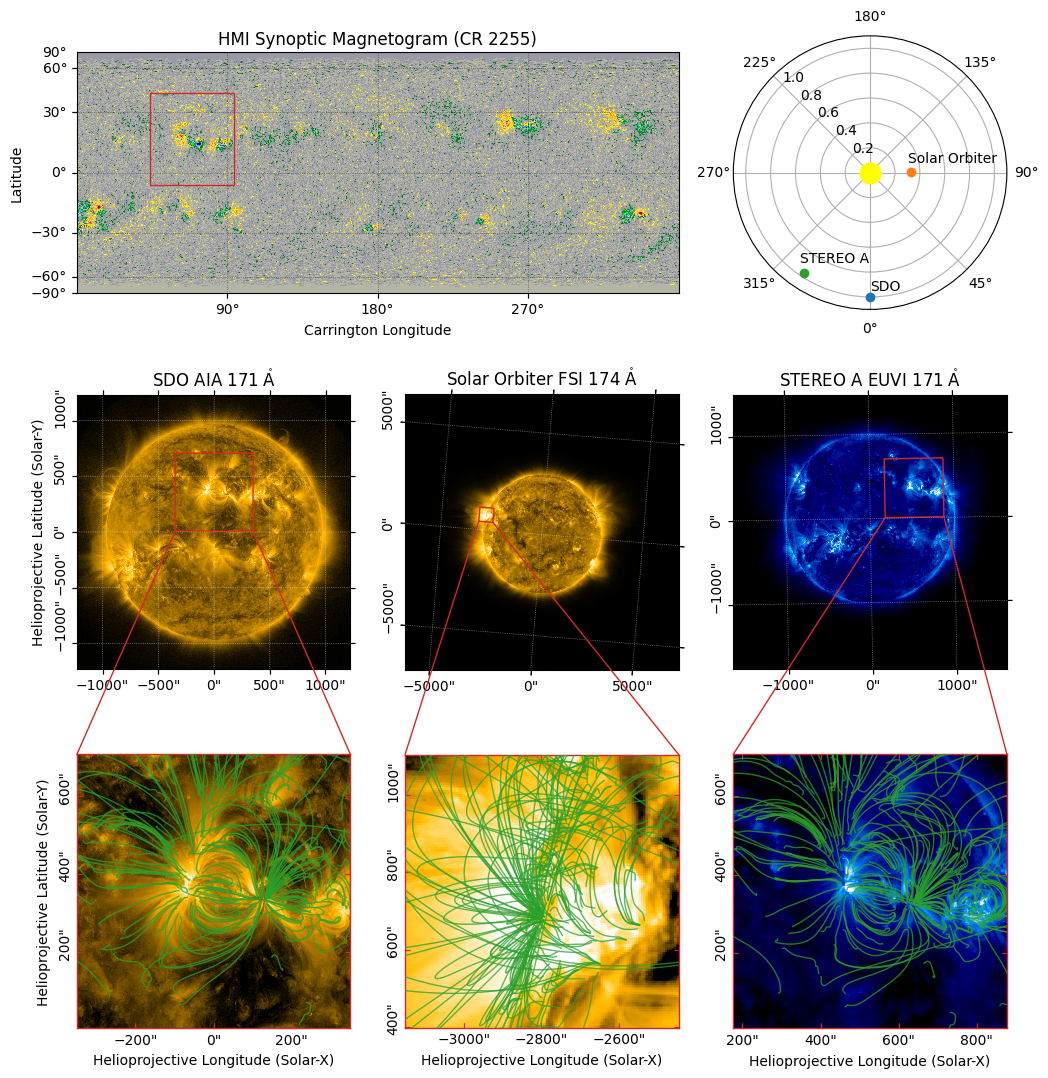

In [ ]:
def add_connectors(ax1, ax2, p1, p2, color='k', lw=1):
    con1 = ConnectionPatch(
        (0, 1), ax1.wcs.world_to_pixel(p1), 'axes fraction', 'data', axesA=ax2, axesB=ax1,
        arrowstyle='-', color=color, lw=lw
    )
    con2 = ConnectionPatch(
        (1, 1), ax1.wcs.world_to_pixel(p2), 'axes fraction', 'data', axesA=ax2, axesB=ax1,
        arrowstyle='-', color=color, lw=lw
    )
    ax2.add_artist(con1)
    ax2.add_artist(con2)

h_w_ratio = 21 / 18
width = 12
frame_color = 'C3'
fig = plt.figure(figsize=(width, width*h_w_ratio))
gs = GridSpec(3, 3, figure=fig)
# Plot HMI synoptic map
ax = fig.add_subplot(gs[0, :2], projection=m_hmi)
m_hmi.plot(axes=ax, title='HMI Synoptic Magnetogram (CR 2255)')
m_hmi.draw_quadrangle(blc_ar_synop, top_right=trc_ar_synop, color=frame_color)
ax.coords[0].grid(color='k')
ax.coords[1].grid(color='k')
# Plot spacecraft locations
ax = fig.add_subplot(gs[0, 2], projection='polar')
ax.plot(0, 0, marker='o', markersize=15, label='Sun', color='yellow')
for m in m_cutouts:
    sat = m.observatory
    coord = m.observer_coordinate
    ax.plot(coord.lon.to('rad'), coord.radius.to(u.AU), 'o', label=sat)
    ax.text(coord.lon.to_value('rad')*1.15, coord.radius.to_value(u.AU)*0.95, sat)
ax.set_theta_zero_location('S')
ax.set_rlabel_position(225)
ax.set_rlim(0, 1.1)
# Plot full-disk EUV images
full_disk_axes = []
for i, m in enumerate([m_aia, m_eui, m_secchi]):
    ax = fig.add_subplot(gs[1, i], projection=m)
    m.plot(axes=ax, clip_interval=(1, 99.99)*u.percent, title=f'{m.observatory} {m.detector} {m.wavelength.to_string(format="latex")}')
    m.draw_quadrangle(m_cutouts[i].bottom_left_coord, top_right=m_cutouts[i].top_right_coord, color=frame_color, lw=1)
    if i:
        ax.coords[1].set_axislabel(' ')
    ax.coords[0].set_axislabel(' ')
    full_disk_axes.append(ax)
    ax.coords[1].set_ticklabel(rotation=90)
# Plot EUV cutouts with field lines
for i, m in enumerate(m_cutouts):
    ax = fig.add_subplot(gs[2, i], projection=m)
    m.plot(
        axes=ax,
        title=False,
        clip_interval=(1, 99.99)*u.percent,
    )
    bounds = ax.axis()
    for c in fline_coords[::8]:
        ax.plot_coord(c, lw=1, color='C2', alpha=0.75)
    ax.axis(bounds)
    if i:
        ax.coords[1].set_axislabel(' ')
    bottom_right = SkyCoord(Tx=m_cutouts[i].top_right_coord.Tx, Ty=m_cutouts[i].bottom_left_coord.Ty, frame=m_cutouts[i].coordinate_frame)
    add_connectors(full_disk_axes[i], ax, m_cutouts[i].bottom_left_coord, bottom_right, color=frame_color, lw=1)
    ax.grid(alpha=0)
    ax.coords[0].set_ticks(direction='in', color=frame_color)
    ax.coords[1].set_ticks(direction='in', color=frame_color)
    ax.coords[0].frame.set_color(frame_color)
    ax.coords[0].frame.set_linewidth(1)
    ax.coords[1].frame.set_color(frame_color)
    ax.coords[1].frame.set_linewidth(1)
    ax.coords[1].set_ticklabel(rotation=90)

plt.subplots_adjust(hspace=0.0)
plt.show()